# Support Vector Machines nos dados covtype de LIBSVM

Iremos treinar os dados para classificação binária usando os dados `covtype` da biblioteca [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/). Veja também [Kaggle-LIBSVM](https://www.kaggle.com/code/tanmayunhale/libsvm-liblinear).

Desta vez, iremos usar o algoritmo SVM:

$$
\min_{w\in {\mathbb R}^{d\times1}} f_n(w)=\frac{1}{n}\sum_{i=1}^n \max\{0,1-y_i(x_i^\top w)\} + \frac{\gamma}{2}\|w\|^2,
$$

onde $x_i\in {\mathbb R}^{d\times1}$, $y_i\in \{-1, 1\}$. Uma diferença em relação à regressão logística é que a função custo não é diferenciável. Um subgradiente num ponto $w$ é dado por

$$
g_n(w) = -\frac{1}{n}\sum_{i=1}^n\mathbb{1}_{\{y_i(x_i^\top w)<1\}}y_ix_i + \gamma w.
$$

Portanto, poderíamos usar o método subgradiente. Neste projeto, entretanto, iremos considerar o caso em que $n$ é muito grande de modo que avaliar $f(w)$ ou $g(w)$ é muito custoso. Note que $f(w)$ é a média empírica de 

$$
F_i(w) := \max\{0,1-y_i(x_i^\top w)\} + \frac{\gamma}{2}\|w\|^2.
$$

Alternativamente iremos usar em cada iteração um único ponto da amostra e aplicar o método subgradiente estocástico com o subgradiente:

$$
G_i(w) := -\mathbb{1}_{\{y_i(x_i^\top w)<1\}}y_ix_i + \gamma w.
$$

NOTA: neste projeto os labels devem estar em $\{-1,1\}$!

In [1]:
# Importação de módulos necesserários:

import matplotlib
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file
from sklearn.utils.extmath import safe_sparse_dot

In [2]:
# Lendo os dados do arquivo covtype e guardando na matriz de dados X e vetor de labels y:

data = load_svmlight_file('./datasets/covtype.bz2')
X, y = data[0].toarray(), data[1]
if (np.unique(y) == [1, 2]).all():
    # Devemos garantir que os labels estão em {-1, 1}
    y[y==1.] = -1
    y[y==2.] = 1
    
n, d = X.shape # tamanho da amostra, número de features    

# Exercício 1: Funções auxiliares

1. Construa uma função `f(w, l2, m)` que toma o iterado `w` e a penalização $\gamma$ (=`l2`) e retorna o valor funcional $f_{m}(w)$ para algum $m\in[n]$.
2. Construa uma função `G(w, i, l2)` toma o iterado `w`, os dados $(x_i,y_i)$ e a penalização $\gamma$ (=`l2`) e retorna o subgradiente $G_i(w)$.
3. Construa uma função `g(w, l2, m)` que toma o iterado `w` e a penalização $\gamma$ (=`l2`) e retorna o subgradiente  $g_{m}(w)$ para algum $m\in[n]$ --- isto é, a média de $m$ subgradientes.
4. Construa uma função `gB(w, l2, B)` que toma o iterado `w` e a penalização $\gamma$ (=`l2`) e retorna o gradiente  $g_{B}(w)=\frac{1}{B}\sum_{i\in I_B}G_i(w)$ para algum $B\in[n]$ onde $I_B\subset[n]$ é escolhido aleatoriamente/uniformente. 

In [3]:
#Escreva o código aqui

# Inicialização

Fixaremos:

In [4]:
m = 30000
l2 = 1e+2
w0 = np.zeros(d)        # ponto inicial
it_max = 80000          # número de iterações
B = 100

# Exercício 2: Método subgradiente estocástico 1 

Iremos implementar o algoritmo [Pegasos](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.cs.huji.ac.il/~shais/papers/ShalevSiSrCo10.pdf)

Construa uma função `sgd(f, G, w0, lr, l2, m, it_max)` que toma como entrada as funções `g()` `G()`, o ponto inicial `w0`, a regularização `l2` $(=\gamma)$, passo `lr`,  `m` e implementa o método subgradiente estocástico em `it_max` iterações iniciando de `w0`:

$$
w_{k+1} = w_k - \alpha_k G_k(w_k), 
$$

com passo $\alpha_k=\frac{lr}{\gamma k}$. **Na $k$-ézima iteração, use o ponto amostral $(x_k,y_k)$, na ordem do data set `X,y`**. Esta função deve retornar a sequência 

$$
k\mapsto f_{m}(w_k)=\frac{1}{m}\sum_{i=1}^{m} \max\{0,1-y_i(x_i^\top w_k)\} + \frac{\gamma}{2}\|w_k\|^2.
$$  

A função também deve retornar o último iterado.

In [5]:
#Escreva o código aqui

In [6]:
# gradient descent
f1 = sgd(f, G, w0, 1e-1, l2, m, it_max)

Time execution for SGD: 30.477485749986954


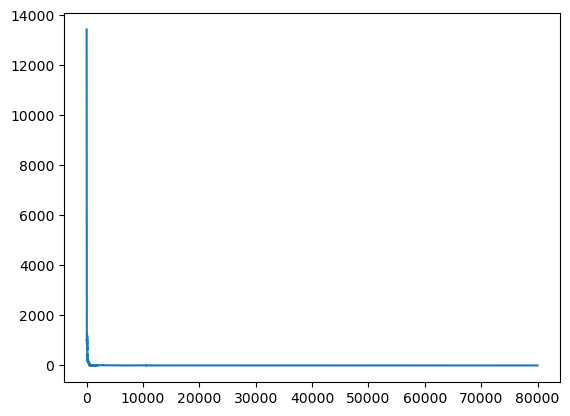

In [7]:
plt.plot(f1[0])

# Exercício 3: Método subgradiente estocástico 2

Construa uma função `sgd2(f, G, w0, lr, l2, m, it_max)` que toma como entrada as funções `g` `G()`, o ponto inicial `w0`, a regularização `l2` $(=\gamma)$, `m` e implementa o método subgradiente estocástico em `it_max` iterações iniciando de `w0`:

$$
w_{k+1} = w_k - \alpha_k G_{i_k}(w_k),
$$

com passo $\alpha_k=\frac{lr}{\gamma k}$, onde **na $k$-ézima iteração, $i_k\in[n]$ é escolhido uniformemente ao acaso, usand o ponto amostral $(x_{i_k},y_{i_k})$**. Esta função deve retornar a sequência 

$$
k\mapsto f_{m}(w_k)=\frac{1}{m}\sum_{i=1}^{m} \max\{0,1-y_i(x_i^\top w_k)\} + \frac{\gamma}{2}\|w_k\|^2.
$$ 

A função também deve retornar o último iterado.

In [8]:
#Escreva o código aqui

In [9]:
# gradient descent
f2 = sgd2(f, G, w0, 1e-1, l2, m, it_max)

Time execution for SGD2: 31.09957774996292


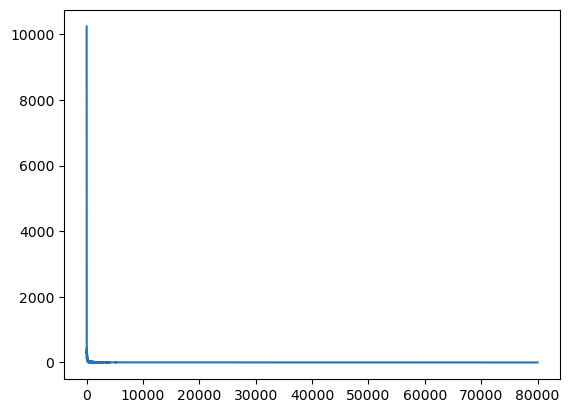

In [10]:
plt.plot(f2[0])

# Exercício 4: Método subgradiente estocástico 3

Construa agora função `sgd3(f, gB, w0, lr, l2, m, B, it_max)` que toma como entrada as funções `f` `gB()`, o ponto inicial `w0`, a regularização `l2` $(=\gamma)$ e implementa o método subgradiente estocástico com mini-batch size `B` em `it_max` iterações iniciando de `w0`:

$$
w_{k+1} = w_k - \alpha_k \cdot\frac{1}{B}\sum_{i\in B_k}G_{i}(w_k),
$$

onde **na $k$-ézima iteração, $B_k\subset\in[n]$ é escolhido uniformemente ao acaso, usando o mini-batch $\{(x_{i},y_{i})\}_{i\in B_k}$**. Esta função deve retornar a sequência 

$$
k\mapsto f_{\text{it_max}}(w_k)=\frac{1}{\text{it_max}}\sum_{i=1}^{\text{it_max}} \max\{0,1-y_i(x_i^\top w_k)\} + \frac{\gamma}{2}\|w_k\|^2.
$$ 

A função também deve retornar o último iterado. Implemente com passo $\alpha_k=\frac{lr}{\gamma k}$.  

In [11]:
#Escreva o código aqui

In [12]:
f3 = sgd3(f, gB, w0, 1e-1, l2, m, B, it_max)

Time execution for SGD2: 37.844150000019


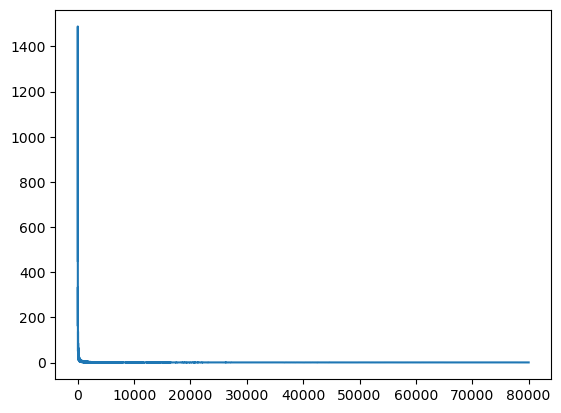

In [13]:
plt.plot(f3[0])

# Exercício 5: 

Implemente num mesmo gráfico os erros $f_{\text{it_max}}(w_k)$ de cada método em função no número de iterações.

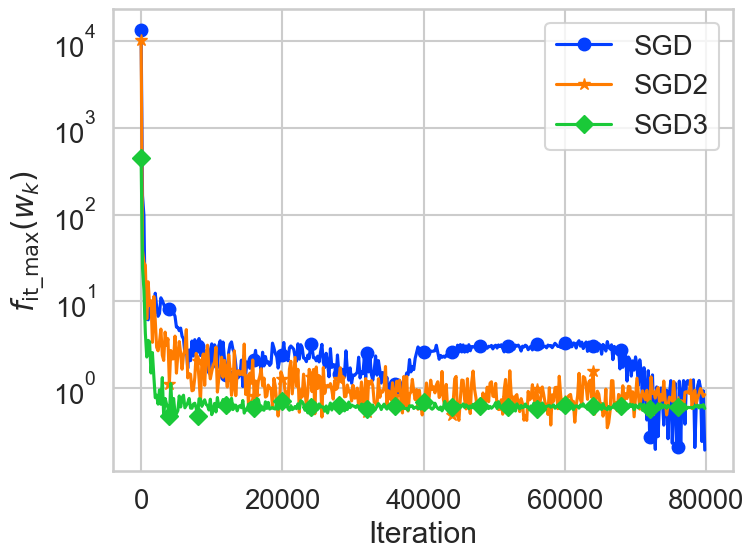

In [14]:
#Escreva o código aqui

# Exercício 6:

Nos exercícios anteriores, usamos os $m$ primeiros pontos de dados `y[:m], X[:m]` para plotar a sequência $k\mapsto f_m(w_k)$. Isto não é ideal já que usamos também todo ou parte de `y[:m], X[:m]` para construir a sequência de iterados $k\mapsto w_k$. Refaça os 3 exercícios anteriores mas antes dividindo o data set `y, X` em duas partes 
`y[n-m:], X[n-m:]` e `y[:n-m], X[:n-m]`. Use o dataset `y[:n-m], X[:n-m]` de tamanho `n-m` para construir a sequência de iterados $k\mapsto w_k$ e `y[n-m:], X[n-m:]` de tamanho `m` para computar $f_m(w)$ para cada iterado $w$. Plote os 3 gráficos correspondentes e depois o gráfico com os 6 métodos diferentes. Você nota alguma diferença?

In [15]:
#Escreva o código aqui

In [16]:
#Escreva o código aqui

Time execution for SGD: 38.07404300000053


In [17]:
#Escreva o código aqui

Time execution for SGD: 36.62013516598381


In [18]:
f3m = sgd3(fm, gBm, w0, 1e-1, l2, m, B, it_max)

Time execution for SGD2: 40.16177495801821


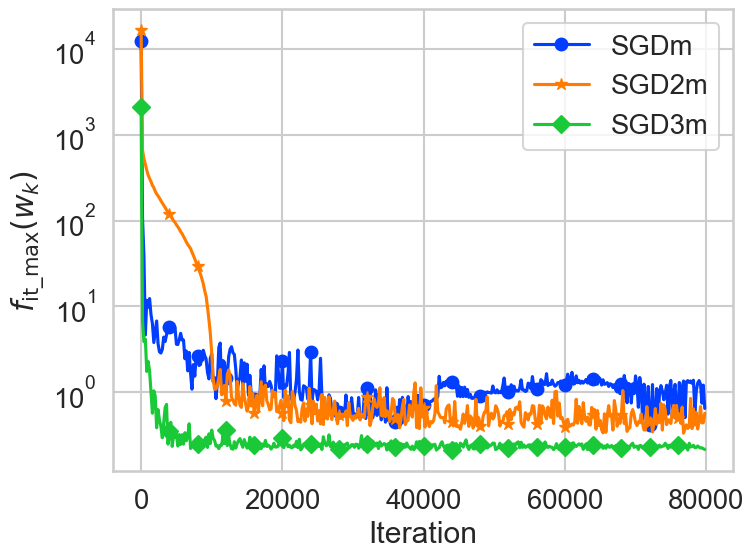

In [19]:
#Escreva o código aqui

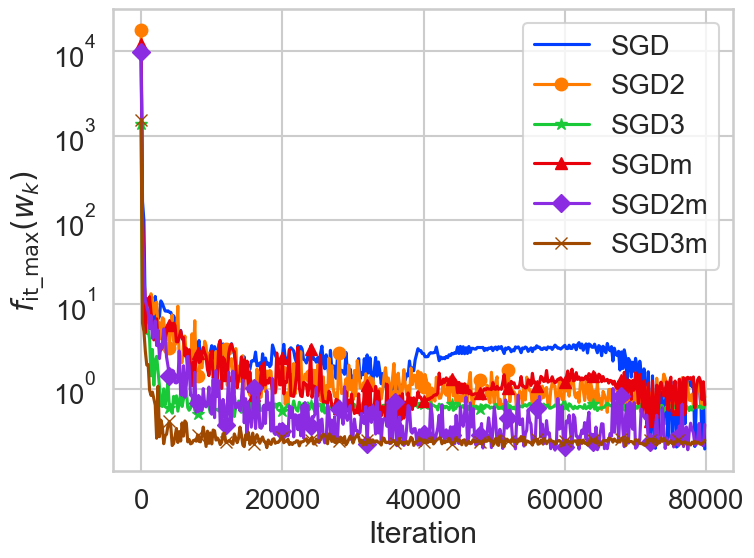

In [203]:
#Escreva o código aqui